## Premier League Soccer/Football Data

The Football-Data Premier League Data [Dataset](https://www.football-data.co.uk/englandm.php) contains sports betting odds data from the 1993/1994 season to the 2022/2023 season. This website provides not only historical football results and betting odds, but also live scores, betting advice, and opportunities for people to bet themselves. The data is meant to be useful by providing insights over time -- insights that may be useful for making money off of identifying opportunities for arbitrage, instances where betting on all outcomes of a game is guaranteed to make a profit.

The data dictionary Notes.txt also provides descriptions for what each column means. There are two main groups of columns: game data and odds data. Firstly, columns relating to game data include the name of the home team, name of the away team, name of referree, shots on goal for each team, score, and number of yellow cards for each team. Secondly, there is odds data from multiple bookmakers and what the odds are for each outcome. Aside from specific odds for each outcome for each bookmaker, there is also some aggregate data such as average and maximum odds.

After cleaning data from 2010-2023, the first step is to identify where there were opportunities for arbitrage to prepare for models to predict both whether there will be arbitrage opportunities as well as the profit margins.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# get file names of all data csvs in this folder
files = glob.glob("*.csv")

In [3]:
all_dfs = []
for file in files:
    try: 
        all_dfs.append(pd.read_csv(file))
    except: 
        print(file)
        continue
premier = pd.concat(all_dfs)

## Data Cleaning

In [4]:
print(premier.shape)
premier.head()
premier["Date"] = pd.to_datetime(premier["Date"])

(4771, 139)


In [5]:
print("Taking data from", premier["Date"].min(), "to", premier["Date"].max())

Taking data from 2010-01-11 00:00:00 to 2023-12-01 00:00:00


In [6]:
premier = premier[(premier["HomeTeam"].notnull()) & premier["AwayTeam"].notnull()]

In [7]:
def drop_cols(df, miss_thresh = 0.5):
    """
    Drops columns in a dataframe where majority of data is missing.
    
    Inputs:
        df [Pandas df]: dataframe of game and odds data.
        miss_thresh [float]: if a column is missing more than 
        this proportion of values, it will be doppred. 
        
    Returns [Pandas df]: a new dataframe without those columns.
    """

    max_missing = len(df) * miss_thresh
    to_drop = df.isna().sum().loc[lambda miss: miss > max_missing].index.tolist()
    to_keep = list(set(df.columns).difference(set(to_drop)))
    print("Dropped", len(to_drop), "columns")
    return df[to_keep]

In [8]:
premier = drop_cols(premier)

Dropped 74 columns


In [9]:
def fill_miss(df):
    """
    Fill missing values in columns with mean of that column. 
    
    Inputs:
        df [Pandas df]: The dataframe to be cleaned.
        
    Returns [Pandas df]: a new dataframe with no missing values.
    """
    
    cols_to_fill = df.isna().sum()[df.isna().sum() > 0].index.tolist()
    for col in cols_to_fill:
        df[col] = df[col].fillna(df[col].mean())
        
    return df

In [10]:
premier = fill_miss(premier)

### Find Arbitrage Opportunities

Arbitrage opportunities are where:
$$(\tfrac{1}{odds_{H}} + \tfrac{1}{odds_{D}} + \tfrac{1}{odds_{A}}) * 100 < 100$$

In [11]:
# Add a column for being a unique identifier
premier["uid"] = np.arange(0, len(premier))

In [12]:
home_odds_cols = ["B365H", "BSH", "BWH", "GBH", "IWH", "LBH", "PSH", "PH", "SOH",
                                            "SBH", "SJH", "SYH", "VCH", "WHH"]
draw_odds_cols = ["B365D", "BSD", "BWD", "GBD", "IWD", "LBD", "PSD", "PD", "SOD",
                                            "SBD", "SJD", "SYD", "VCD", "WHD"]
away_odds_cols = ["B365A", "BSA", "BWA", "GBA", "IWA", "LBA", "PSA", "PA", "SOA", 
                                            "SBA", "SJA", "SYA", "VCA", "WHA"]
# Some cols may be missing esp. with some columns with a lot of missing vals dropped
# Take the intersection of these columns and the dataframe's columns
h_odds_cols = list(set(premier.columns.tolist()).intersection(set(home_odds_cols)))
d_odds_cols = list(set(premier.columns.tolist()).intersection(set(draw_odds_cols)))
a_odds_cols = list(set(premier.columns.tolist()).intersection(set(away_odds_cols)))

In [13]:
def is_arb(odds_home, odds_draw, odds_away):
    """
    Helper function for the function find_arb to calcualte betting odds margin given three odds,
    and returns a boolean of if it is under 100%, indicating an opportunity of arbitrage
    as well as the betting odds margin.
    
    Inputs:
        odds_home [float]: odds that the home team will win.
        odds_draw [float]: odds that there will be a draw.
        odds_away [float]: odds that the away team will win.
    
    Returns [tuple(bool, float)]: True if there is an opportunity for arbitrage, otherwise
        False. The float is the proportion of profit available to the better if it is an 
        arbitrage opportunity, or otherwise the proportion of profit available to the bookmaker.
    """
    implied_prob_home = 1/odds_home
    implied_prob_draw = 1/odds_draw
    implied_prob_away = 1/odds_away
    
    margin = (implied_prob_home + implied_prob_draw + implied_prob_away) * 100
    if margin < 100:
        # There is an opportunity for Arbitrage
        return True, 100 - margin
    # margin >= 100 in this case, odds are against better
    return False, margin - 100

In [14]:
def find_arb(df, ho_cols = home_odds_cols, do_cols = draw_odds_cols, ao_cols = away_odds_cols):
    """
    Find the arbitrage opportunities for each game based on the various bookmakers'
    odds for the home team winning, a draw, and the away team winning. 
    
    Inputs:
        df [Pandas df]: dataframe with a unique identifier column named uid, and
            column names for every string in ho_cols, do_cols, and ao_cols. Each row 
            represents one game, where the corresponding element in each bookmakers'
            odds columns is for that game.
        ho_cols [list[str]]: column names of bookmakers' odds for the home team 
            winning.
        do_cols [list[str]]: column names of bookmakers' odds for the game ending
            in a draw.
        ao_cols [list[str]]: column names of bookmakers' odds for the away team 
            winning.
        
    Returns [dict[int] -> [list[tuple(str, str, str, float)]]]: A dictionary with
        keys as unique identifiers for each game with arbitrage opportunities, 
        with the values being a list. The list's first element is the name of 
        the column for the book and outcome of home winning. Then it is the name
        of the column indicative of the book and outcome of draw winning, followed 
        by the respective column name for the book for away oods. The fourth and 
        final element in the list is a float giving the margin of profit.
    """
    
    h_odds = df[h_odds_cols]
    d_odds = df[d_odds_cols]
    a_odds = df[a_odds_cols]

    books_and_margin = {}
    
    for uid in df["uid"]:
        home, draw, away = (dict(h_odds.iloc[uid, :]), 
                        dict(d_odds.iloc[uid, :]), dict(a_odds.iloc[uid, :]))
        # Try all combinations of home, draw, and away odds
        for h_book_odds in home.items():
            bookh, oddsh = h_book_odds
            for d_book_odds in draw.items():
                bookd, oddsd = d_book_odds
                for a_book_odds in away.items():
                    booka, oddsa = a_book_odds
                    
                    # Check if arbitrage opp. exists using the helper function
                    arb_bool, my_margin = is_arb(oddsh, oddsd, oddsa)
                    
                    if arb_bool:
                        to_store = (bookh, bookd, booka, my_margin)
                        if to_store == ('PSH', 'PSD', 'PSA', 10.43352294809739):
                            return bookh, bookd, booka, my_margin
                        current_opps = books_and_margin.get(uid, [])
                        current_opps.append(to_store)
                        books_and_margin[uid] = current_opps
  
    return books_and_margin

In [15]:
my_arb_dict = find_arb(premier, h_odds_cols, d_odds_cols, a_odds_cols)

In [16]:
print(len(my_arb_dict.keys()), "opportunities for arbitrage!!")

2960 opportunities for arbitrage!!


In [17]:
premier["Arbitrage Opportunity"] = premier.apply(lambda r: r["uid"] in my_arb_dict.keys(), axis = 1)

In [18]:
def best_for_game(uid):
    """
    What is the best bet that can be placed? Helper function for best_for_games. 
    Relies on the global variable my_arb_dict to contain information accessible
    by each game's unique id.
    Inputs:
        uid [int]: unique id for a game.
    Returns [tuple(str, str, str, float)]: A tuple containing the an abbeviation
        corresponding to the book to bet on for home winning, draw winning, and 
        away winning as the first three string elements. The last element is the
        maximum profit margin(a proportion greater than 0) if there exsts one or
        more arbitrage opportunities for that game. If no arbitrage opportunity 
        exists, returns a tuple of four Nones.
    """
    if uid in my_arb_dict: 
        all_opp_info = my_arb_dict[uid]
        # At index 3 of each tuple in the list is the margin of profit
        profits = [tupl[3] for tupl in all_opp_info]
        bet_info = all_opp_info[np.argmax(profits)]
        return bet_info

    # For the purpose of being unpacked by find_best_margin
    return (None, None, None, None)

In [19]:
def best_for_games(df):
    """
    Goes row-by-row for each game in the dataframe using the helper function 
    best_for_game to find the books to bet on in order to get the best profit
    margin.

    Inputs:
        df [Pandas df]: Dataframe of game and odds data

    Returns [Pandas df]: New datafrane with four new columns about the bets 
        that could have been placed to get the bet profit!
    """
    # Store in list for easy creation of new dataframe columns
    home_book_bets, draw_book_bets, away_book_bets, profits = [], [], [], []

    for ind in range(len(df)):
        row_uid = df.iloc[ind, :]["uid"]
        home_book, draw_book, away_book, profit = best_for_game(row_uid)
        home_book_bets.append(home_book)
        draw_book_bets.append(draw_book)
        away_book_bets.append(away_book)
        profits.append(profit)

    df["Home Book Bet"] = home_book_bets
    df["Draw Book Bet"] = draw_book_bets
    df["Away Book Bet"] = away_book_bets
    df["Bet Profit"] = profits

    return df

In [20]:
prem = best_for_games(premier)

In [21]:
print("There are profit margins as high as ", 
    np.round(prem["Bet Profit"].max(), 3), "%!")

There are profit margins as high as  65.079 %!


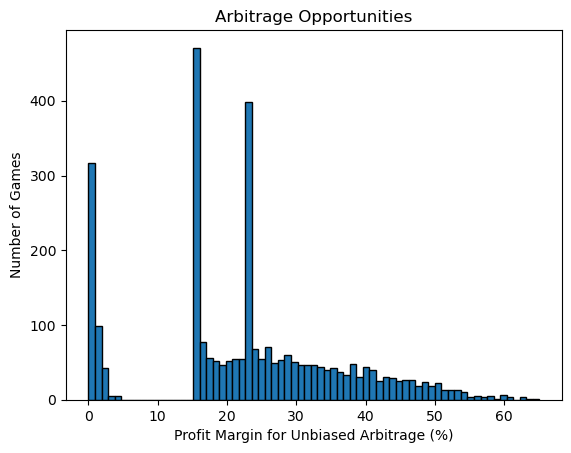

In [22]:
plt.hist(prem["Bet Profit"], bins = int(np.sqrt(len(prem))), edgecolor = "black")
plt.xlabel("Profit Margin for Unbiased Arbitrage (%)")
plt.ylabel("Number of Games")
plt.title("Arbitrage Opportunities")
plt.show()